# Lección 4: Protocolo de codificación densa

Los estados entrelazados, como lo hemos visto en las sesiones anteriores, permiten realizar cosas bastante interesantes. La propiedad de entrelazamiento entre un par de partículas dio pie para la proposición de diferentes protocolos cuánticos cuyas posibles aplicaciones se exploran aún en la actualidad.

En esta lección analizaremos en detalle el protocolo de codificación densa. Este protocolo es posible gracias a las propiedades del entrelazamiento entre dos partículas. 

Las fuentes de este tipo de partículas las llamaremos fuentes EPR por los autores del artículo *Can Quantum-Mechanical Description of Physical Reality Be Considered Complete?* publicado por Albert Einstein, Boris Podolsky, y Nathan Rosen en 1935 en donde se muestra como el formalismos de la mecánica cuántica permite que un par de partículas compartan esta propiedad de entrelazamiento.

**SUPER IMPORTANTE:** En este ejemplo intentaremos presentar al lector cómo simular el protocolo cuántico de teleportación en un computador cuántico. Esta sesiónes está disponible en nuestro servidor de MyBinder.
​
<p align="center">
  <a href="https://mybinder.org/v2/gh/QC-FEM/QC-CrashCourse/HEAD">
    <img src="https://mybinder.org/badge_logo.svg">
  </a>
</p>

Como de costumbre realizamos las importaciones necesarias para neustro circuito.

In [1]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram,state_visualization
from qiskit.quantum_info.operators import Operator
import matplotlib.pyplot as plt
import numpy as np

Para realizar este protocolo primero tenemos que definir lo que se conoce como un *alfabeto*, esto es, a ciertos estados cuánticos, les vamos a asignar cierta información. En este caso presentaremos el protocolo para enviar un mensaje de 2 bits. entonces la asignación que definimos va a ser.
$$ 00 \longrightarrow |\Phi^+\rangle_{AB} = \frac{1}{\sqrt{2}}\left(|00 \rangle + |11\rangle\right)$$
$$ 01 \longrightarrow |\Psi^+\rangle_{AB} = \frac{1}{\sqrt{2}}\left(|01 \rangle + |10\rangle\right)$$
$$ 10 \longrightarrow |\Phi^-\rangle_{AB} = \frac{1}{\sqrt{2}}\left(|00 \rangle - |11\rangle\right)$$
$$ 11 \longrightarrow |\Psi^-\rangle_{AB} = \frac{1}{\sqrt{2}}\left(|01 \rangle - |10\rangle\right)$$

El protocolo se puede ilustrar en la siquiente imagen.

<img src="Lec_4_Dense_coding_files/QDCP.png" alt="drawing" width="500">

- Paso 1: Una fuente EPR, la cual es una fuente de partículas entrelazadas, entrega un par de partículas entrelazadas a Alice y Bob. A la partícula de Alice la llamamos $A$ y a la partícula de Bob la llamamos $B$. Estas partículas deben estar entrelazadas en un estado de Bell, en este ejemplo partícular elegimos el estado de la forma $|\Phi^{+}\rangle_{AB} = \frac{1}{\sqrt{2}}|00\rangle + \frac{1}{\sqrt{2}} |11\rangle$.
- Paso 2: Bob realiza una operación unitaria sobre su qubit dependiendo de el mensaje que el desea enviar, las posibilidades que el tiene son:

$$I_B |\Phi^+\rangle\rightarrow |\Phi^+\rangle \rightarrow 00$$

$$X_B |\Phi^+\rangle\rightarrow |\Psi^+\rangle \rightarrow 01$$

$$Z_B |\Phi^+\rangle\rightarrow |\Phi^-\rangle \rightarrow 10$$

$$X_B Z_B |\Phi^+\rangle\rightarrow |\Psi^-\rangle \rightarrow 11\hspace{1.1em}$$

   Por ejemplo si el quisiera enviar el mensaje $01$, entonces debe aplicar una compuerta NOT sobre su qubit para formar este mensaje.

- Paso 3: Luego de que Bob realiza la operación unitaria sobre su qubit, el se lo envía a Alice para que ella realiza una medición del estado de Bell (BSM) entre los dos qubits y de acuerdo a su resultado ella sabrá que mensaje le quiso enviar Bob.

Para realizar el protocolo definimos la una función que es la que va a entrelazar los dos qubits en el estado deseado.

In [2]:
def entangle_qubits(circuit, q_Alice, q_Bob):
    
    ## Entrelazamos un par de qubits en un estado de Bell
    circuit.h(q_Alice)                 ## Hadamard sobre el qubit de Alice
    circuit.cx(q_Alice,q_Bob)          ## CNOT para entrelazar los qubits de Alice y Bob
     
    
    return circuit

Luego definimos una función que, de acuerdo con el mensaje que desea enviar Bob se realiza una operación unitaria

In [7]:
def Bob_transformation (circuit, q_Bob, message):
    
    ## Si el mensaje es '00' No se realiza ninguna operación
    if (message == '00'):
        return circuit
    
    ## Si el mensaje es '01' se niega el qubit de bob
    elif (message == '01'):
        circuit.x(q_Bob)
        return circuit
    
    ## Si el mensaje es '10' se agrega una fase relativa de pi al qubit de Bob
    elif (message == '10'):
        circuit.z(q_Bob)
        return circuit
    
    ## Si el mensaje es '11' se niega y se agrega una fase relativa de pi al qubit de bob
    elif (message == '11'):
        circuit.z(q_Bob)
        circuit.x(q_Bob)
        return circuit

Ahora definimos una función que nos permite realizar una medición de un estado de Bell entre dos qubits.

In [8]:
def bell_measurement(circuit, q_Alice, q_Bob, c_Alice, c_Bob):
    
    ## Acá Alice realiza la medición del estado de Bell para esto lleva los estados a dicha base y realiza la medición
    circuit.cx(q_Alice, q_Bob)
    circuit.h(q_Alice)
    
    ## Los resultados que obtenga Alice indicarán El mensaje que le quiso enviar Bob
    circuit.barrier()
    circuit.measure(q_Alice, c_Alice)
    circuit.measure(q_Bob, c_Bob)

    return circuit

Ahora iniciamos un circuito y ejecutamos el protocolo

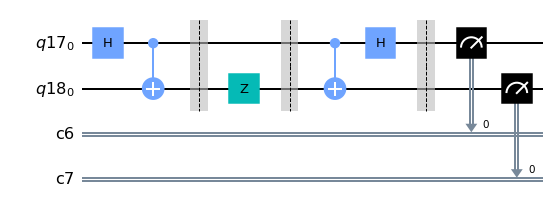

In [13]:
## Inicializamos todo el circuito 
qubit_Alice = QuantumRegister(1)
qubit_Bob = QuantumRegister(1)
cr_Alice = ClassicalRegister(1)
cr_Bob = ClassicalRegister(1)

## Acá ejecutamos el protocolo, primero inicializamos nuestro circuito
qc = QuantumCircuit(qubit_Alice, qubit_Bob, cr_Alice, cr_Bob)

## Paso 1: Entregamos a Bob y a Alice un par de partículas enrtelazadas
entangle_qubits(qc, qubit_Alice, qubit_Bob)
qc.barrier()

## Paso 2: Bob realiza una una operación de acuerdo al mensaje que desea enviar
message = '10'
Bob_transformation(qc,  qubit_Bob, message)
qc.barrier()

## Paso 3: Alice realiza una medición del estado de Bell con el qubit de Bob para ver el mensaje
bell_measurement(qc, qubit_Alice, qubit_Bob, cr_Alice, cr_Bob)


## El circuito toma la forma
qc.draw(output='mpl')

Ahora mostramos el histograma de las mediciones que obtuvo Alice.

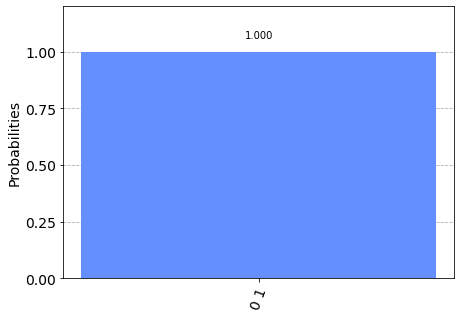

In [14]:
## Simulamos el circuito
backend = Aer.get_backend('qasm_simulator')
counts = execute(qc,backend,shots=10000).result().get_counts()


## Mostramos el histograma para el qubit de Bob
plot_histogram(counts)

Teniendo en cuenta que el qubit de arriba es el de Alice y el de abajo es el de Bob, significa que el resultado que obtuvo Alice es $10$, es decir, es el mensaje que Bob quería enviar.

Y ahora ¿Dónde esta la codificación?. Es importante notar que para enviar este mensaje de dos bits Bob **únicamente manípulo un qubit**. Si Bob quisiera enviar este mensaje a Alice, el tendría que manipular 2 bits clásicos, sin embargo, el protocolo muestra cómo Bob puede enviar un mensaje de 2 bits manipulando únicamente un qubit.

## Referencias

* Einstein, Podolsky & Rosen. **Can Quantum-Mechanical Description of Physical Reality Be Considered Complete?**. Phys. Rev. 47, 777, 1935.
* Nielsen & Chuang. **Quantum Computation and Quantum Information**. Cambridge University Press, 2010.
* Bouwmeester D., Ekert A. & Zeilinger A. **The Physics of Quantum Information**. Springer-Verlag, 2001. 
* Wilde. **Quantum Information Theory**. Cambridge University Press, 2013.

Muchas gracias por leer esta publicación! Abajo se encuentran links a las lecciones siguientes en el Crash Course de QC-FEM.